# Introduction
<hr style = "border:2px solid black" ></hr>


**What?** Estimating volatility with classical vs. ML methods



# Imports
<hr style = "border:2px solid black" ></hr>

In [1]:
import numpy as np
from scipy.stats import norm
import scipy.optimize as opt
import yfinance as yf
import pandas as pd
import datetime
import time
from arch import arch_model
import matplotlib.pyplot as plt
from numba import jit
from sklearn.metrics import mean_squared_error as mse
import warnings

import quantecon as qe
from quantecon import MarkovChain
import networkx as nx
from pprint import pprint 

import pyflux as pf
from scipy.stats import kurtosis

warnings.filterwarnings('ignore')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

OMP: Info #273: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


# Volatility
<hr style = "border:2px solid black" ></hr>


- **Markowitz** proposed his celebra‐ ted portfolio theory in which he defined volatility as standard deviation so that from then onward, finance became more intertwined with mathematics.

- Modeling volatility amounts to modeling uncertainty so that we better understand and approach uncertainty, enabling us to have good enough approximations of the real world. 
    
- To gauge the extent to which proposed models account for the real-world situation, we need to calculate the **return volatility**, which is also known as **realised volatility**.



# Imports data
<hr style = "border:2px solid black" ></hr>

In [2]:
stocks = '^GSPC'
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2021, 8, 1)
s_p500 = yf.download(stocks, start=start, end = end, interval='1d')

[*********************100%***********************]  1 of 1 completed


In [3]:
s_p500

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3991400000
2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000
2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000
2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000
2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4389590000
...,...,...,...,...,...,...
2021-07-26,4409.580078,4422.729980,4405.450195,4422.299805,4422.299805,2679110000
2021-07-27,4416.379883,4416.379883,4372.509766,4401.459961,4401.459961,3381080000
2021-07-28,4402.950195,4415.470215,4387.009766,4400.640137,4400.640137,3215130000


# Volatility
<hr style = "border:2px solid black" ></hr>

In [4]:
# Find the percentage difference between the values in current row and previous row:
s_p500.pct_change()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,0.014419,0.002434,0.011732,0.003116,0.003116,-0.375903
2010-01-06,0.002693,0.002252,0.003798,0.000546,0.000546,0.996234
2010-01-07,0.000493,0.002870,-0.002319,0.004001,0.004001,0.059932
2010-01-08,0.003740,0.002565,0.004331,0.002882,0.002882,-0.167168
...,...,...,...,...,...,...
2021-07-26,0.006478,0.001710,0.005535,0.002382,0.002382,-0.232507
2021-07-27,0.001542,-0.001436,-0.007477,-0.004712,-0.004712,0.262016
2021-07-28,-0.003041,-0.000206,0.003316,-0.000186,-0.000186,-0.049082


In [5]:
# Calculating the returns of the S&P 500 based on adjusted closing prices.
ret = 100 * (s_p500.pct_change()[1:]['Adj Close'])
realized_vol = ret.rolling(5).std()

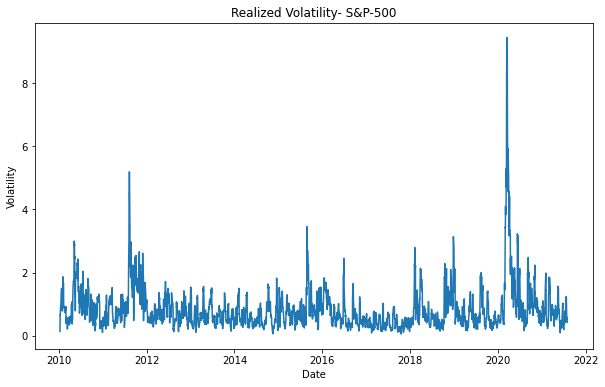

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol.index,realized_vol)
plt.title('Realized Volatility- S&P-500') 
plt.ylabel('Volatility')
plt.xlabel('Date') 
plt.show()


- The realized volatility of S&P 500 over the period of 2010–2021. 
- The most striking observation is the spikes around the COVID-19 pandemic.



In [7]:
retv = ret.values

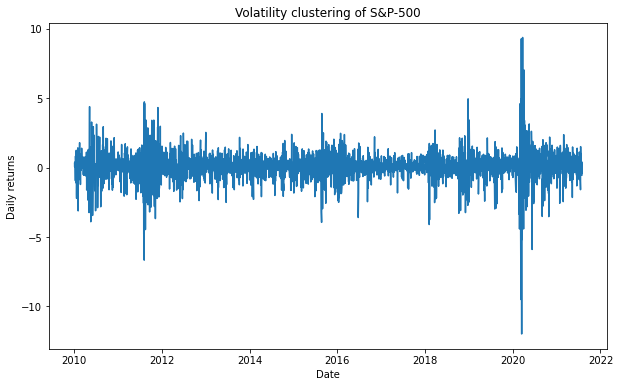

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(s_p500.index[1:], ret)
plt.title('Volatility clustering of S&P-500') 
plt.ylabel('Daily returns')
plt.xlabel('Date') 
plt.show()


- Similar to spikes in realized volatility, the volatilty clusterring suggests some large movements, and, unsurprisingly, these ups and downs happen around important events such as the COVID-19 pandemic in mid-2020.



# Method to estimate volatility
<hr style = "border:2px solid black" ></hr>


- We'll compare two methods: classical and ML.
- Some of the classical methods are:
    - ARCH
    - GARCH
    - EGARCH
- On the ML side:
    - SVR
    - MLP
    - DL
    - Bayesian approach



## ARCH


- Proposed by Eagle (1982) and is known as the ARCH model. 
- The ARCH model is a univariate model and based on historical asset returns. 
- ARCH is a univariate and nonlinear model in which volatility is estimated with the square of past returns. 
- ARCH enjoyes the property of time-varying conditional variance so that ARCH is able to model the phenomenon known as **volatility clustering**. That is, large changes tend to be followed by large changes of either sign, and small changes tend to be followed by small changes. 
- Hence, once an important announcement is made to the market, it might result in huge volatility.
    


In [9]:
n = 252
split_date = ret.iloc[-n:].index

In [10]:
sgm2 = ret.var()
K = ret.kurtosis()
alpha = (-3.0 * sgm2 + np.sqrt(9.0 * sgm2 ** 2 - 12.0 * 
                             (3.0 * sgm2 - K) * K)) / (6 * K)
omega = (1 - alpha) * sgm2
initial_parameters = [alpha, omega]
omega, alpha

(0.6341564916391557, 0.46673132307801635)

In [11]:
@jit(nopython=True, parallel=True)
def arch_likelihood(initial_parameters, retv):
    omega = abs(initial_parameters[0])
    alpha = abs(initial_parameters[1])
    T = len(retv)
    logliks = 0
    sigma2 = np.zeros(T)
    sigma2[0] = np.var(retv)
    for t in range(1, T):
        sigma2[t] = omega + alpha * (retv[t - 1]) ** 2
    logliks = np.sum(0.5 * (np.log(sigma2)+retv ** 2 / sigma2))
    return logliks

In [12]:
logliks = arch_likelihood(initial_parameters, retv)
logliks

1451.5757030518018

In [13]:
def opt_params(x0, retv):
    opt_result = opt.minimize(arch_likelihood, x0=x0, args=(retv),
                              method='Nelder-Mead',
                              options={'maxiter': 5000})
    params = opt_result.x
    print('\nResults of Nelder-Mead minimization\n{}\n{}'
          .format(''.join(['-'] * 28), opt_result))
    print('\nResulting params = {}'.format(params))
    return params

In [14]:
params = opt_params(initial_parameters, retv)


Results of Nelder-Mead minimization
----------------------------
 final_simplex: (array([[0.70152949, 0.39126701],
       [0.70159538, 0.39127449],
       [0.70155899, 0.39135604]]), array([1384.45490351, 1384.45490656, 1384.45490779]))
           fun: 1384.454903510853
       message: 'Optimization terminated successfully.'
          nfev: 58
           nit: 30
        status: 0
       success: True
             x: array([0.70152949, 0.39126701])

Resulting params = [0.70152949 0.39126701]


In [15]:
def arch_apply(ret):
    omega = params[0]
    alpha = params[1]
    T = len(ret)
    sigma2_arch = np.zeros(T + 1)
    sigma2_arch[0] = np.var(ret)
    for t in range(1, T):
        sigma2_arch[t] = omega + alpha * ret[t - 1] ** 2
    return sigma2_arch

In [16]:
sigma2_arch = arch_apply(ret)

In [17]:
arch = arch_model(ret, mean='zero', vol='ARCH', p=1).fit(disp='off')
print(arch.summary())

                        Zero Mean - ARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -4061.27
Distribution:                  Normal   AIC:                           8126.54
Method:            Maximum Likelihood   BIC:                           8138.50
                                        No. Observations:                 2913
Date:                Sun, Sep 11 2022   Df Residuals:                     2913
Time:                        15:15:00   Df Model:                            0
                            Volatility Model                            
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.7014  5.002e-02     14.023  1.129e-44 [  0.603,  0.79

In [18]:
bic_arch = []

for p in range(1, 5):
    arch = arch_model(ret, mean='zero', vol='ARCH', p=p)\
        .fit(disp='off')
    bic_arch.append(arch.bic)
    if arch.bic == np.min(bic_arch):
        best_param = p
arch = arch_model(ret, mean='zero', vol='ARCH', p=best_param)\
    .fit(disp='off')
print(arch.summary())
forecast = arch.forecast(start=split_date[0])
forecast_arch = forecast

                        Zero Mean - ARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -3709.51
Distribution:                  Normal   AIC:                           7429.03
Method:            Maximum Likelihood   BIC:                           7458.91
                                        No. Observations:                 2913
Date:                Sun, Sep 11 2022   Df Residuals:                     2913
Time:                        15:15:00   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.2794  2.580e-02     10.829  2.498e-27   [  0.22

In [19]:
rmse_arch = np.sqrt(mse(realized_vol[-n:] / 100,
                        np.sqrt(forecast_arch
                        .variance.iloc[-len(split_date):]
                        / 100)))
print('The RMSE value of ARCH model is {:.4f}'.format(rmse_arch))

The RMSE value of ARCH model is 0.0896


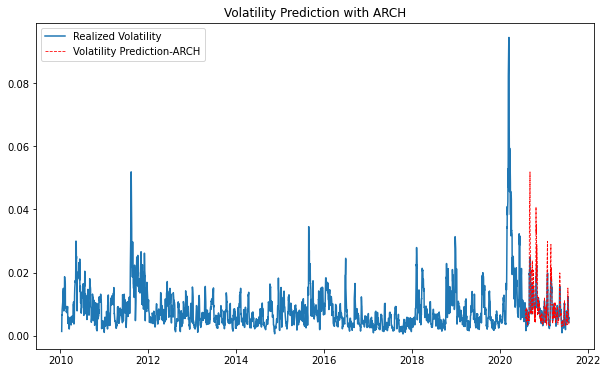

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_arch.variance.iloc[-len(split_date):] / 100,
         "r--", lw=0.8, label='Volatility Prediction-ARCH')
plt.title('Volatility Prediction with ARCH', fontsize=12)
plt.legend()
plt.show()

## GARCH


-



In [21]:
a0 = 0.0001
sgm2 = ret.var()
K = ret.kurtosis()
h = 1 - alpha / sgm2
alpha = np.sqrt(K * (1 - h ** 2) / (2.0 * (K + 3)))
beta = np.abs(h - omega)
omega = (1 - omega) * sgm2
initial_parameters = np.array([omega, alpha, beta])
print('Initial parameters for omega, alpha, and beta are \n{}\n{}\n{}'
      .format(omega, alpha, beta))

Initial parameters for omega, alpha, and beta are 
0.4350565592754938
0.5130099184547643
0.026635632698685408


In [22]:
retv = ret.values

In [23]:
@jit(nopython=True, parallel=True)
def garch_likelihood(initial_parameters, retv):
    omega = initial_parameters[0]
    alpha = initial_parameters[1]
    beta = initial_parameters[2]
    T =  len(retv)
    logliks = 0
    sigma2 = np.zeros(T)
    sigma2[0] = np.var(retv)
    for t in range(1, T):
        sigma2[t] = omega + alpha * (retv[t - 1]) ** 2 + beta * sigma2[t-1]
    logliks = np.sum(0.5 * (np.log(sigma2) + retv ** 2 / sigma2))
    return logliks

In [24]:
logliks = garch_likelihood(initial_parameters, retv)
print('The Log likelihood  is {:.4f}'.format(logliks))

The Log likelihood  is 1386.4565


In [25]:
def garch_constraint(initial_parameters):  
    alpha = initial_parameters[0]
    gamma = initial_parameters[1]
    beta = initial_parameters[2]
    return np.array([1 - alpha - beta])

In [26]:
bounds = [(0.0, 1.0), (0.0, 1.0), (0.0, 1.0)]

In [27]:
def opt_paramsG(initial_parameters, retv):
    opt_result = opt.minimize(garch_likelihood, 
                              x0=initial_parameters,
                              constraints=np.array([1 - alpha - beta]), 
                              bounds=bounds, args = (retv),
                              method='Nelder-Mead',
                              options={'maxiter': 5000})
    params = opt_result.x
    print('\nResults of Nelder-Mead minimization\n{}\n{}'\
          .format('-' * 35, opt_result))
    print('-' * 35)
    print('\nResulting parameters = {}'.format(params))
    return params

In [28]:
params = opt_paramsG(initial_parameters, retv)


Results of Nelder-Mead minimization
-----------------------------------
 final_simplex: (array([[0.0392492 , 0.17440926, 0.78939289],
       [0.03928828, 0.17446935, 0.7893081 ],
       [0.03926896, 0.17443597, 0.78938038],
       [0.03928055, 0.17437603, 0.78938064]]), array([978.43816789, 978.43817204, 978.43817305, 978.43817835]))
           fun: 978.4381678874342
       message: 'Optimization terminated successfully.'
          nfev: 172
           nit: 99
        status: 0
       success: True
             x: array([0.0392492 , 0.17440926, 0.78939289])
-----------------------------------

Resulting parameters = [0.0392492  0.17440926 0.78939289]


In [29]:
def garch_apply(ret):
        omega = params[0]
        alpha = params[1]
        beta = params[2]
        T = len(ret)
        sigma2 = np.zeros(T + 1)
        sigma2[0] = np.var(ret)
        for t in range(1, T):
            sigma2[t] = omega + alpha * ret[t - 1] ** 2 +\
                        beta * sigma2[t-1]
        return sigma2

In [30]:
garch = arch_model(ret, mean='zero', vol='GARCH', p=1, o=0, q=1)\
        .fit(disp='off')
print(garch.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3654.98
Distribution:                  Normal   AIC:                           7315.97
Method:            Maximum Likelihood   BIC:                           7333.90
                                        No. Observations:                 2913
Date:                Sun, Sep 11 2022   Df Residuals:                     2913
Time:                        15:15:02   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0393  8.429e-03      4.664  3.100e-06 [2.

In [31]:
bic_garch = []

for p in range(1, 5):
    for q in range(1, 5):
        garch = arch_model(ret, mean='zero',vol='GARCH', p=p, o=0, q=q)\
                .fit(disp='off')
        bic_garch.append(garch.bic)
        if garch.bic == np.min(bic_garch):
            best_param = p, q
garch = arch_model(ret, mean='zero', vol='GARCH',
                   p=best_param[0], o=0, q=best_param[1])\
        .fit(disp='off')
print(garch.summary())
forecast = garch.forecast(start=split_date[0])
forecast_garch = forecast

                       Zero Mean - GARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3654.98
Distribution:                  Normal   AIC:                           7315.97
Method:            Maximum Likelihood   BIC:                           7333.90
                                        No. Observations:                 2913
Date:                Sun, Sep 11 2022   Df Residuals:                     2913
Time:                        15:15:03   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0393  8.429e-03      4.664  3.100e-06 [2.

In [32]:
rmse_garch = np.sqrt(mse(realized_vol[-n:] / 100,
                         np.sqrt(forecast_garch\
                         .variance.iloc[-len(split_date):] 
                         / 100)))
print('The RMSE value of GARCH model is {:.4f}'.format(rmse_garch))

The RMSE value of GARCH model is 0.0878


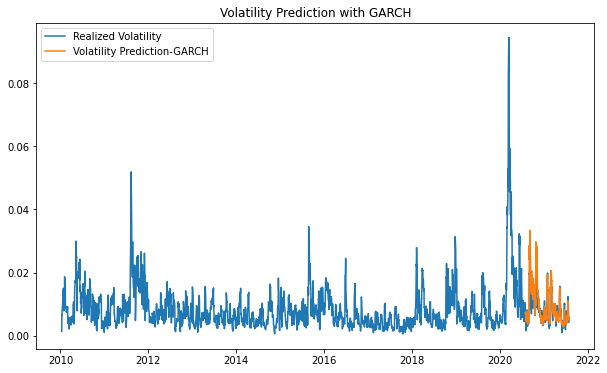

In [33]:
plt.figure(figsize=(10,6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_garch.variance.iloc[-len(split_date):] / 100, 
         label='Volatility Prediction-GARCH')
plt.title('Volatility Prediction with GARCH', fontsize=12)
plt.legend()
plt.show()

## GJR-GARCH

In [34]:
bic_gjr_garch = []

for p in range(1, 5):
    for q in range(1, 5):
        gjrgarch = arch_model(ret, mean='zero', p=p, o=1, q=q)\
                   .fit(disp='off')
        bic_gjr_garch.append(gjrgarch.bic)
        if gjrgarch.bic == np.min(bic_gjr_garch):
            best_param = p, q
gjrgarch = arch_model(ret,mean='zero', p=best_param[0], o=1,
                      q=best_param[1]).fit(disp='off')
print(gjrgarch.summary())
forecast = gjrgarch.forecast(start=split_date[0])
forecast_gjrgarch = forecast

                     Zero Mean - GJR-GARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -3591.15
Distribution:                  Normal   AIC:                           7190.30
Method:            Maximum Likelihood   BIC:                           7214.21
                                        No. Observations:                 2913
Date:                Sun, Sep 11 2022   Df Residuals:                     2913
Time:                        15:15:04   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0430  7.754e-03      5.547  2.908e-08 

In [35]:
rmse_gjr_garch = np.sqrt(mse(realized_vol[-n:] / 100,
                             np.sqrt(forecast_gjrgarch\
                             .variance.iloc[-len(split_date):]
                             / 100)))
print('The RMSE value of GJR-GARCH models is {:.4f}'
      .format(rmse_gjr_garch))

The RMSE value of GJR-GARCH models is 0.0882


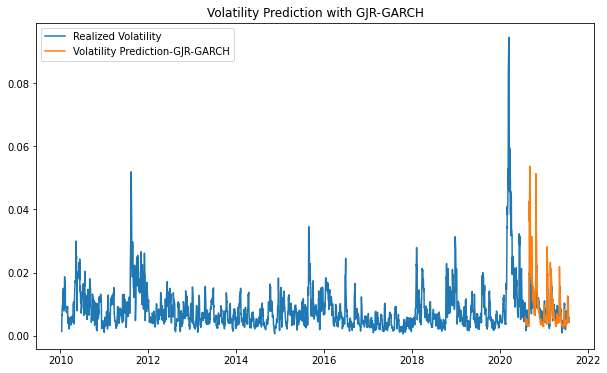

In [36]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_gjrgarch.variance.iloc[-len(split_date):] / 100, 
         label='Volatility Prediction-GJR-GARCH')
plt.title('Volatility Prediction with GJR-GARCH', fontsize=12)
plt.legend()
plt.show()

## EGARCH

In [37]:
bic_egarch = []

for p in range(1, 5):
    for q in range(1, 5):
        egarch = arch_model(ret, mean='zero', vol='EGARCH', p=p, q=q)\
                 .fit(disp='off')
        bic_egarch.append(egarch.bic)
        if egarch.bic == np.min(bic_egarch):
            best_param = p, q
egarch = arch_model(ret, mean='zero', vol='EGARCH',
                    p=best_param[0], q=best_param[1])\
         .fit(disp='off')
print(egarch.summary())
forecast = egarch.forecast(start=split_date[0])
forecast_egarch = forecast

                       Zero Mean - EGARCH Model Results                       
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -3673.53
Distribution:                  Normal   AIC:                           7353.05
Method:            Maximum Likelihood   BIC:                           7370.98
                                        No. Observations:                 2913
Date:                Sun, Sep 11 2022   Df Residuals:                     2913
Time:                        15:15:06   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      2.4573e-03  6.769e-03      0.363      0.717 

In [38]:
rmse_egarch = np.sqrt(mse(realized_vol[-n:] / 100,
                          np.sqrt(forecast_egarch.variance\
                          .iloc[-len(split_date):] / 100)))
print('The RMSE value of EGARCH models is {:.4f}'.format(rmse_egarch))

The RMSE value of EGARCH models is 0.0904


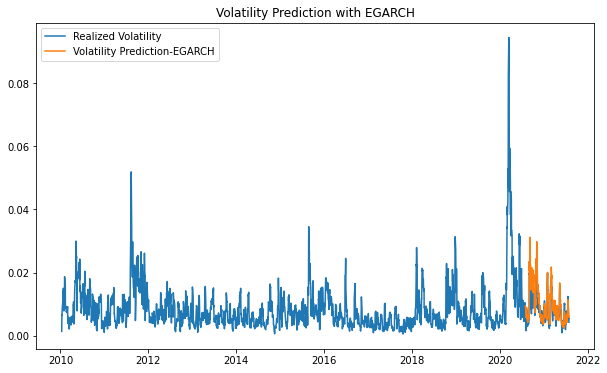

In [39]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_egarch.variance.iloc[-len(split_date):] / 100,
         label='Volatility Prediction-EGARCH')
plt.title('Volatility Prediction with EGARCH', fontsize=12)
plt.legend()
plt.show()

## SVR-GARCH


- Combining two models gets us SVR-GARCH.



In [40]:
from sklearn.svm import SVR
from scipy.stats import uniform as sp_rand
from sklearn.model_selection import RandomizedSearchCV

In [41]:
realized_vol = ret.rolling(5).std()
realized_vol = pd.DataFrame(realized_vol)
realized_vol.reset_index(drop=True, inplace=True)

In [42]:
returns_svm = ret ** 2
returns_svm = returns_svm.reset_index()
del returns_svm['Date']

In [43]:
X = pd.concat([realized_vol, returns_svm], axis=1, ignore_index=True)
X = X[4:].copy()
X = X.reset_index()
X.drop('index', axis=1, inplace=True)

In [44]:
realized_vol = realized_vol.dropna().reset_index()
realized_vol.drop('index', axis=1, inplace=True)

In [45]:
svr_poly = SVR(kernel='poly', degree=2)
svr_lin = SVR(kernel='linear')
svr_rbf = SVR(kernel='rbf')

### SVR-GARCH-Linear

In [46]:
para_grid = {'gamma': sp_rand(),
             'C': sp_rand(),
             'epsilon': sp_rand()}
clf = RandomizedSearchCV(svr_lin, para_grid)
clf.fit(X.iloc[:-n].values, 
        realized_vol.iloc[1:-(n-1)].values.reshape(-1,))
predict_svr_lin = clf.predict(X.iloc[-n:])

In [47]:
predict_svr_lin = pd.DataFrame(predict_svr_lin)
predict_svr_lin.index = ret.iloc[-n:].index

In [48]:
rmse_svr = np.sqrt(mse(realized_vol.iloc[-n:] / 100,
                       predict_svr_lin / 100))
print('The RMSE value of SVR with Linear Kernel is {:.6f}'
      .format(rmse_svr))

The RMSE value of SVR with Linear Kernel is 0.000501


In [49]:
realized_vol.index = ret.iloc[4:].index

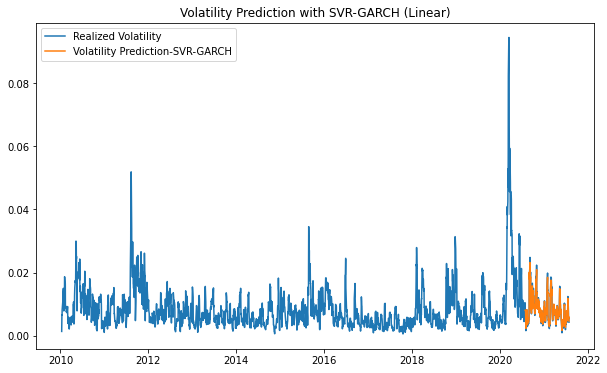

In [50]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(predict_svr_lin / 100, label='Volatility Prediction-SVR-GARCH')
plt.title('Volatility Prediction with SVR-GARCH (Linear)', fontsize=12)
plt.legend()
plt.show()

### SVR-GARCH RBF

In [51]:
para_grid ={'gamma': sp_rand(),
            'C': sp_rand(),
            'epsilon': sp_rand()}
clf = RandomizedSearchCV(svr_rbf, para_grid)
clf.fit(X.iloc[:-n].values, 
        realized_vol.iloc[1:-(n-1)].values.reshape(-1,))
predict_svr_rbf = clf.predict(X.iloc[-n:])

In [52]:
predict_svr_rbf = pd.DataFrame(predict_svr_rbf)
predict_svr_rbf.index = ret.iloc[-n:].index

In [53]:
rmse_svr_rbf = np.sqrt(mse(realized_vol.iloc[-n:] / 100,
                           predict_svr_rbf / 100))
print('The RMSE value of SVR with RBF Kernel is  {:.6f}'
      .format(rmse_svr_rbf))

The RMSE value of SVR with RBF Kernel is  0.000947


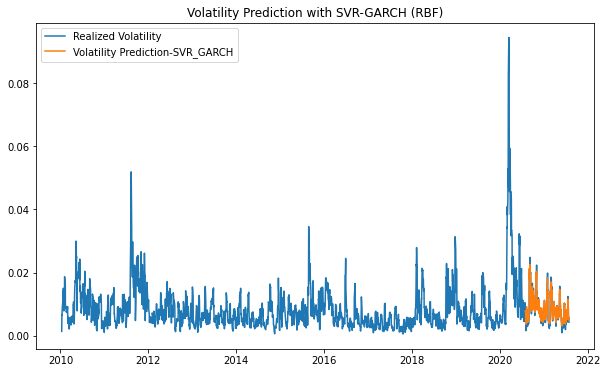

In [54]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(predict_svr_rbf / 100, label='Volatility Prediction-SVR_GARCH')
plt.title('Volatility Prediction with SVR-GARCH (RBF)', fontsize=12)
plt.legend()
plt.show()

### SVR-GARCH Polynomial

In [ ]:
para_grid = {'gamma': sp_rand(),
            'C': sp_rand(),
            'epsilon': sp_rand()}
clf = RandomizedSearchCV(svr_poly, para_grid)
clf.fit(X.iloc[:-n].values, 
        realized_vol.iloc[1:-(n-1)].values.reshape(-1,))
predict_svr_poly = clf.predict(X.iloc[-n:])

In [ ]:
predict_svr_poly = pd.DataFrame(predict_svr_poly)
predict_svr_poly.index = ret.iloc[-n:].index

In [ ]:
rmse_svr_poly = np.sqrt(mse(realized_vol.iloc[-n:] / 100,
                            predict_svr_poly / 100))
print('The RMSE value of SVR with Polynomial Kernel is {:.6f}'\
      .format(rmse_svr_poly))

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol/100, label='Realized Volatility')
plt.plot(predict_svr_poly/100, label='Volatility Prediction-SVR-GARCH')
plt.title('Volatility Prediction with SVR-GARCH (Polynomial)',
          fontsize=12)
plt.legend()
plt.show()

## NN-GARCH

In [ ]:
from sklearn.neural_network import MLPRegressor
NN_vol = MLPRegressor(learning_rate_init=0.001, random_state=1) 
para_grid_NN = {'hidden_layer_sizes': [(100, 50), (50, 50), (10, 100)],
               'max_iter': [500, 1000],
               'alpha': [0.00005, 0.0005 ]}
clf = RandomizedSearchCV(NN_vol, para_grid_NN)
clf.fit(X.iloc[:-n].values, 
        realized_vol.iloc[1:-(n-1)].values.reshape(-1, ))
NN_predictions = clf.predict(X.iloc[-n:])

In [ ]:
NN_predictions = pd.DataFrame(NN_predictions)
NN_predictions.index = ret.iloc[-n:].index

In [ ]:
rmse_NN = np.sqrt(mse(realized_vol.iloc[-n:] / 100,
                      NN_predictions / 100))
print('The RMSE value of NN is {:.6f}'.format(rmse_NN))

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(NN_predictions / 100, label='Volatility Prediction-NN')
plt.title('Volatility Prediction with Neural Network', fontsize=12)
plt.legend()
plt.show()

## DL-GARCH

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
model = keras.Sequential(
    [layers.Dense(256, activation="relu"),
     layers.Dense(128, activation="relu"),
     layers.Dense(1, activation="linear"),])

In [ ]:
model.compile(loss='mse', optimizer='rmsprop')

In [ ]:
epochs_trial = np.arange(100, 400, 4)
batch_trial = np.arange(100, 400, 4)
DL_pred = []
DL_RMSE = []
for i, j, k in zip(range(4), epochs_trial, batch_trial):
    model.fit(X.iloc[:-n].values,
              realized_vol.iloc[1:-(n-1)].values.reshape(-1,),
              batch_size=k, epochs=j, verbose=False)
    DL_predict = model.predict(np.asarray(X.iloc[-n:]))
    DL_RMSE.append(np.sqrt(mse(realized_vol.iloc[-n:] / 100,
                            DL_predict.flatten() / 100)))
    DL_pred.append(DL_predict)
    print('DL_RMSE_{}:{:.6f}'.format(i+1, DL_RMSE[i]))

In [ ]:
DL_predict = pd.DataFrame(DL_pred[DL_RMSE.index(min(DL_RMSE))])
DL_predict.index = ret.iloc[-n:].index

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100,label='Realized Volatility')
plt.plot(DL_predict / 100,label='Volatility Prediction-DL')
plt.title('Volatility Prediction with Deep Learning',  fontsize=12)
plt.legend()
plt.show()

## Bayesian Approach


- The way we approach probability is of central importance in the sense that it distinguishes the classical (or Frequentist) and Bayesian approaches. 
- According to the former, the relative frequency will converge to the true probability. However, a Bayesian application is based on the subjective interpretation. 
- Unlike the Frequentists, Bayesian statisticians consider the probability distribution as uncertain, and **it is revised as new information comes in**.




- Bayes’ theorem is attractive but it comes with a cost, which is analytical intractability and hard to solve analytically. However, there are methods used to approximate this computational issues: 
    - Quadrature approximation
    - Maximum a posteriori estimation (MAP)
    - Grid approach
    - Sampling-based approach
    - Metropolis–Hastings
    - Gibbs sampler
    - No U-Turn sampler
    



- Both Metropolis–Hastings and Gibbs sampler rests on the Markov chain Monte Carlo (MCMC) method.
- The Markov chain is a model used to describe the transition probabilities among states. A chain is called Markovian if the probability of the current state st depends only on the most recent state.
- In a nutshell, the MCMC method helps us gather IID samples from posterior density so that we can calculate the poste‐ rior probability.
    


In [ ]:
P = [[0.5, 0.2, 0.3],
     [0.2, 0.3, 0.5],
     [0.2, 0.2, 0.6]]

mc = qe.MarkovChain(P, ('studying', 'travelling', 'sleeping'))
mc.is_irreducible

In [ ]:
states = ['studying', 'travelling', 'sleeping']
initial_probs = [0.5, 0.3, 0.6]
state_space = pd.Series(initial_probs, index=states, name='states')

In [ ]:
q_df = pd.DataFrame(columns=states, index=states)
q_df = pd.DataFrame(columns=states, index=states)
q_df.loc[states[0]] = [0.5, 0.2, 0.3]
q_df.loc[states[1]] = [0.2, 0.3, 0.5]
q_df.loc[states[2]] = [0.2, 0.2, 0.6]

In [ ]:
def _get_markov_edges(Q):
    edges = {}
    for col in Q.columns:
        for idx in Q.index:
            edges[(idx,col)] = Q.loc[idx,col]
    return edges
edges_wts = _get_markov_edges(q_df)
pprint(edges_wts)

In [ ]:
G = nx.MultiDiGraph()
G.add_nodes_from(states)
for k, v in edges_wts.items():
    tmp_origin, tmp_destination = k[0], k[1]
    G.add_edge(tmp_origin, tmp_destination, weight=v, label=v)

pos = nx.drawing.nx_pydot.graphviz_layout(G, prog='dot')
nx.draw_networkx(G, pos)
edge_labels = {(n1, n2):d['label'] for n1, n2, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G , pos, edge_labels=edge_labels)
nx.drawing.nx_pydot.write_dot(G, 'mc_states.dot')

In [ ]:
# Configuring GARCH model using the PyFlux library
model = pf.GARCH(ret.values, p=1, q=1)

In [ ]:
# Printing the estimation of latent variables (parameters) 
print(model.latent_variables)

In [ ]:
# Adjusting the priors for the model latent variables 
model.adjust_prior(1, pf.Normal())
model.adjust_prior(2, pf.Normal())

In [ ]:
# Fitting the model using M-H process
x = model.fit(method='M-H', iterations='1000')
print(x.summary())

In [ ]:
# Plotting the latent variables
model.plot_z([1, 2])

In [ ]:
# Plotting the fitted model
model.plot_fit(figsize=(15, 5))

In [ ]:
# Plotting the histogram for posterior check
model.plot_ppc(T=kurtosis, nsims=1000)


- Now that the training is done we can move to the prediction.
- Prediction analysis is done for the 252 steps ahead.
- To measure how good our model is, we'll used the RMSE.
    


In [ ]:
bayesian_prediction = model.predict_is(n, fit_method='M-H')

In [ ]:
bayesian_RMSE = np.sqrt(mse(realized_vol.iloc[-n:] / 100,
                         bayesian_prediction.values / 100))
print('The RMSE of Bayesian model is {:.6f}'.format(bayesian_RMSE))

In [ ]:
bayesian_prediction.index = ret.iloc[-n:].index

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100,
         label='Realized Volatility')
plt.plot(bayesian_prediction['Series'] / 100,
         label='Volatility Prediction-Bayesian')
plt.title('Volatility Prediction with M-H Approach', fontsize=12)
plt.legend()
plt.show()

# Clean-up directory
<hr style = "border:2px solid black" ></hr>

# Conclusions
<hr style = "border:2px solid black" ></hr>


- Volatility prediction is a key as it used to gauge uncertainty. 
- Traditional method can be used, being them parametric they are not flexible.
- To remedy this issue, data-driven ML model can be used.



# References
<hr style = "border:2px solid black" ></hr>


- https://github.com/abdullahkarasan/mlfrm/blob/main/codes/chp_4.ipynb
- Machine Learning for Financial Risk Management with Python Abdullah Karasan

